## Geese and Overloading

#### What is Polymorphism?

**The ability to write code that looks similar, but operates on different types.**

In other words, a single interface serves entities of different types. 


### ABC's

Earlier we used ABCs as a vehicle to document interfaces. We saw that:

- we could use the @abstractmethod without any implementation but with some documentation to communicate a protocol. These are the equivalent of pure virtual methods in C++.
- we could not instantiate an ABC
- an implementation could be registered, or a subclass-hook defined in an ABC which indicated that a protocol was satisfied. 

But dissapointingly, we find in general that there is no checking that our implementation implemented our interface.

In [1]:
import abc
class SimpleSetInterface(abc.ABC):
    
    @abc.abstractmethod
    def __len__(self):
        "A SimpleSet has a length"
        
    @abc.abstractmethod
    def __iter__(self):
        "iteration. order is not guaranteed"
    
    @abc.abstractmethod
    def __contains__(self, item)->bool:
        "A test for whether item is in set"
        
    @abc.abstractmethod
    def add(self, item)->None:
        "add item to set"
        
    @abc.abstractmethod
    def rem(self, item)->None:
        "delete item from set"
        
    @abc.abstractmethod
    def union(self, other:"SimpleSetInterface")->"SimpleSetInterface":
        "union with another set"
        
    @abc.abstractmethod
    def intersection(self, other:"SimpleSetInterface")->"SimpleSetInterface":
        "intersection with another set"

In [2]:
class SimpleSetter():
    pass

SimpleSetInterface.register(SimpleSetter)
issubclass(SimpleSetter, SimpleSetInterface)

True

In [3]:
ss=SimpleSetter()
len(ss)

TypeError: object of type 'SimpleSetter' has no len()

But if we subclass, we get the checking for free

In [4]:
class SimpleSetter2(SimpleSetInterface):
    pass

ss=SimpleSetter2()
len(ss)

TypeError: Can't instantiate abstract class SimpleSetter2 with abstract methods __contains__, __iter__, __len__, add, intersection, rem, union

#### Goosetyping

Alex Martelli, calls using ABC's goosetyping, where there are explicit `isinstance` checks against an ABC. 

Why do these ABC's in the first place? Why not just use ducktyping and be done with it? 

Indeed for most of your (client) code you should never be doing this. Explicit `isinstance` checks lose generality

We have seen ( and shall soon see again) one reason: **API documentation.**  

There is a second reason: **enforcing an API contract**. (plugins)

But there is a third reason, its **useful in simplifying polymorphism**

This is important in operator overloading, as we shall see soon

Indeed, when we use `@singledispatch`, we should only be testing against ABC's. So, whenever we use adhoc polymorphism, we'll use goose typing against ABC's and no more.

```python
@htmlize.register(numbers.Integral) 
def _(n):
    return '<pre>{0} (0x{0:x})</pre>'.format(n)
```

#### Common ABCs

Diagram from Fluent:
![](abcuml.png)

Also, the `numbers` module defines the “numerical tower”:

`Number < Complex < Real < Rational < Integral`

#### Useful tips for  ABCs, inheritance, and Polymorphism:

- do not subclass built in types such as strings: defined in C, there be demons

- make sure that inheritance only does **is-a**. Anything else and you have polluted your child classes.

- Distinguish Interface Inheritance from Implementation Inheritance

Inheritance for code reuse is an implementation detail. Often it can be replaced by composition and delegation. Our "SimpleSet" has-a list, and was not supposed to inherit from it. But there are cases where using inheritance is useful, as in non-abstract methods in an ABC which provide default implementations we can use or replace.

- Favor Object Composition **has-a** Over Class Inheritance.

- Make Interfaces Explicit with ABCs

If a class is designed to define an interface/API, use a ABC

- Use Mixins for Code Reuse or protocol mixing

- Don’t Subclass from More Than One Concrete Class

### OperatorOverloading

**How do we define `+`, `-`, unary `-`, etc for our own classes**

The Python object model has dunder types such as `__len__`. But it also defines one-additional-argument dunders such as `__add__`, which take an "object-to-add", a `other`,  as an argument. 

- First take the implicit first argument `self`, like in `__len__`. 
- The correct one is picked up by seeing the class's lookup table, in a form of ad-hoc polymorphism augmented by inheritance. 

#### Second argument `other`

We might want to dispatch based on different types of this second argument..
- here we can use explicit single dispatch through a "operator" specific lookup table, 
- or even more simply through if/elif checks against ABCs...the goose typing we taked about earlier. 

In each of these cases our lookup is now implicitly method based.

So operator overloading in a dynamic language such as python is just ad-hoc polymorphism augmented by inheritance and goose typing.

Fluent:
>Operator overloading allows user-defined objects to interoperate with infix operators such as + and * or unary operators like - and ~. More generally, function invocation ((), `__call__`), attribute access (., `__getattr__`), and item access/slicing ([], `__getitem__`) are also operators in Python....

>Python strikes a good balance between flexibility, usability, and safety by imposing some limitations:
• We cannot overload operators for the built-in types.
• We cannot create new operators, only overload existing ones.
• A few operators can’t be overloaded: is, and, or, not (but the bitwise &, |, ~, can).

Gosling, quoted in Fluent, explaining why java does not have operator overloading:
>Then there’s a community of about 10 percent that have actually used operator over‐ loading appropriately and who really care about it, and for whom it’s actually really important; this is almost exclusively people who do numerical work, where the notation is very important to appealing to people’s intuition, because they come into it with an intuition about what the + means, and the ability to say “a + b” where a and b are complex numbers or matrices or something really does make sense.

Here is an example. We have added unary - and +, and binary equality

In [5]:
#example from Fluent
from array import array 
import reprlib
import math
import numbers
import functools
import operator
import itertools

class Vector:
    typecode = 'd'
    
    def __init__(self, components):
        self._components = array(self.typecode, components)
        
    def __iter__(self):
        return iter(self._components)
    
    def __repr__(self):
        components = reprlib.repr(self._components) 
        components = components[components.find('['):-1] 
        return 'Vector({})'.format(components)
    
    def __eq__(self, other):
        return (len(self) == len(other) and
            all(a == b for a, b in zip(self, other)))
    
    def __len__(self):
        return len(self._components)
    
    def __getitem__(self, index): 
        cls = type(self)
        
        if isinstance(index, slice):
            return cls(self._components[index])
        elif isinstance(index, numbers.Integral): 
            return self._components[index]
        else:
            msg = '{.__name__} indices must be integers' 
            raise TypeError(msg.format(cls))
            
    def __neg__(self):
        return Vector(-x for x in self) 
    
    def __pos__(self):
        return Vector(self)

In [6]:
v1 = Vector([3, 4])
v2 = Vector([3.1, 4.2])
v3 = Vector([3, 4, 5])
v4 = Vector([3, 4])
v1==v2, v1==v4, list(v1), v1

(False, True, [3.0, 4.0], Vector([3.0, 4.0]))

In [7]:
+v1, -v1

(Vector([3.0, 4.0]), Vector([-3.0, -4.0]))

Notice we return new Vectors. 

**Unary or Infix operations should never change arguments**

Also, protocols are great!

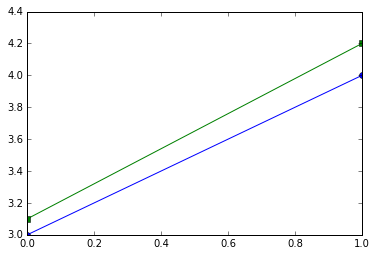

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(v1,'o-')
plt.plot(v2,'s-');

What happens on addition?

In [9]:
v1+ v2

TypeError: unsupported operand type(s) for +: 'Vector' and 'Vector'

In [ ]:
v1 + [1,2]

Ok, so lets add that!

In [ ]:
for x in zip([1,2],[1]):
    print(x)

In [ ]:
#example from Fluent
from array import array 
import reprlib
import math
import numbers
import functools
import operator
import itertools

class Vector:
    typecode = 'd'
    
    def __init__(self, components):
        self._components = array(self.typecode, components)
        
    def __iter__(self):
        return iter(self._components)
    
    def __repr__(self):
        components = reprlib.repr(self._components) 
        components = components[components.find('['):-1] 
        return 'Vector({})'.format(components)
    
    def __eq__(self, other):
        return (len(self) == len(other) and
            all(a == b for a, b in zip(self, other)))
    
    def __abs__(self):
        return math.sqrt(sum(x * x for x in self))
    
    def __bool__(self): 
        return bool(abs(self))
    
    def __len__(self):
        return len(self._components)
    
    def __getitem__(self, index): 
        cls = type(self)
        
        if isinstance(index, slice):
            return cls(self._components[index])
        elif isinstance(index, numbers.Integral): 
            return self._components[index]
        else:
            msg = '{.__name__} indices must be integers' 
            raise TypeError(msg.format(cls))
            
    def __neg__(self):
        return Vector(-x for x in self) 
    
    def __pos__(self):
        return Vector(self)
    
    def _check_length(function):
        def _check_length_helper(self , rhs):
            if not len(self)==len(rhs):
                raise ValueError(str(self)+' and '+str(rhs)+' must have the same length')
            return function(self,rhs)
        return _check_length_helper
    
    @_check_length
    def __add__(self, rhs):
        pairs = zip(self, rhs)
        return Vector(a + b for a, b in pairs)

In [10]:
v1 = Vector([3, 4])
v2 = Vector([3.1, 4.2])
v3 = Vector([3, 4, 5])
v4 = Vector([3, 4])
v1 + v2

TypeError: unsupported operand type(s) for +: 'Vector' and 'Vector'

In [11]:
v1+v3 

TypeError: unsupported operand type(s) for +: 'Vector' and 'Vector'

In [12]:
v1 + 5

TypeError: unsupported operand type(s) for +: 'Vector' and 'int'

In [13]:
v1 + [3,5]

TypeError: unsupported operand type(s) for +: 'Vector' and 'list'

In [14]:
v1+range(0,2)

TypeError: unsupported operand type(s) for +: 'Vector' and 'range'

???? What happened here???????

`other` implements the iterator protocol and everything just works.

But:

In [15]:
[1,2] + v1

TypeError: can only concatenate list (not "Vector") to list

#### How overloading is done?

The process for infix ops is this (from Fluent):


1. If a has `__add__`, call a.`__add__`(b) and return result unless it’s NotImplemented. 
2. If a doesn’t have `__add__`, or calling it returns NotImplemented, check if b has `__radd__`, then call `b.__radd__(a)` and return result unless it’s NotImplemented. 
3. If b doesn’t have `__radd__`, or calling it returns NotImplemented, raise TypeError with an unsupported operand types message.

#### ..the "right" methods

`__radd__` method is called the “right” version of `__add__`. 
To make the mixed-types addition  work, we need to also implement the `__radd__` which Python calls if and only if:
- the left operand does not implement `__add__ ` : here it does but because its a list it thinks we want to concatenate
- or if the left-hand operand does but returns `NotImplemented` 

From Fluent

>if an operator special method cannot return a valid result because of type incom‐ patibility, it should return NotImplemented and not raise TypeError. By returning NotImplemented, you leave the door open for the implementer of the other operand type to perform the operation when Python tries the reversed method call.

We'll use duck-typing here and just catch exceptions, returning `NotImplemented`, thus enabling the reverse lookup. 

In [16]:
#example from Fluent
from array import array 
import reprlib
import math
import numbers
import functools
import operator
import itertools

class Vector:
    typecode = 'd'
    
    def __init__(self, components):
        self._components = array(self.typecode, components)
        
    def __iter__(self):
        return iter(self._components)
    
    def __repr__(self):
        components = reprlib.repr(self._components) 
        components = components[components.find('['):-1] 
        return 'Vector({})'.format(components)
    
    def __eq__(self, other):
        return (len(self) == len(other) and
            all(a == b for a, b in zip(self, other)))
    
    def __abs__(self):
        return math.sqrt(sum(x * x for x in self))
    
    def __bool__(self): 
        return bool(abs(self))
    
    def __len__(self):
        return len(self._components)
    
    def __getitem__(self, index): 
        cls = type(self)
        
        if isinstance(index, slice):
            return cls(self._components[index])
        elif isinstance(index, numbers.Integral): 
            return self._components[index]
        else:
            msg = '{.__name__} indices must be integers' 
            raise TypeError(msg.format(cls))
            
    def __neg__(self):
        return Vector(-x for x in self) 
    
    def __pos__(self):
        return Vector(self)
    
    def _check_length_helper(self , rhs):
        if not len(self)==len(rhs):
            raise ValueError(str(self)+' and '+str(rhs)+' must have the same length')
    
    def __add__(self, rhs):
        try:
            self._check_length_helper(rhs)
            pairs = zip(self, rhs)
            return Vector(a + b for a, b in pairs)
        except TypeError:
            return NotImplemented
    
    def __radd__(self, other): # other + self delegates to self.__add__
        return self + other

In [17]:
v1 = Vector([3, 4])
v1 + [1,2] # v1.__add__([1,2])

Vector([4.0, 6.0])

In [18]:
[1,2]+v1 #v1.__radd__([1,2])

Vector([4.0, 6.0])

Ok, but:

In [19]:
v1+4

TypeError: unsupported operand type(s) for +: 'Vector' and 'int'

In [20]:
4 + v1

TypeError: unsupported operand type(s) for +: 'Vector' and 'int'

We should support this. What should be our semantics? I think it should add a constant to every item, like in numpy. This where goose-typing comes in with "case" or dispatch based dealing with other types



In [23]:
#example from Fluent
from array import array 
import reprlib
import math
import numbers
import functools
import operator
import itertools

class Vector:
    typecode = 'd'
    
    def __init__(self, components):
        self._components = array(self.typecode, components)
        
    def __iter__(self):
        return iter(self._components)
    
    def __repr__(self):
        components = reprlib.repr(self._components) 
        components = components[components.find('['):-1] 
        return 'Vector({})'.format(components)
    
    def __eq__(self, other):
        if isinstance(other, Vector):
            return (len(self) == len(other) and
                all(a == b for a, b in zip(self, other)))
        else:
            return NotImplemented
    
    def __abs__(self):
        return math.sqrt(sum(x * x for x in self))
    
    def __bool__(self): 
        return bool(abs(self))
    
    def __len__(self):
        return len(self._components)
    
    def __getitem__(self, index): 
        cls = type(self)
        
        if isinstance(index, slice):
            return cls(self._components[index])
        elif isinstance(index, numbers.Integral): 
            return self._components[index]
        else:
            msg = '{.__name__} indices must be integers' 
            raise TypeError(msg.format(cls))
            
    def __neg__(self):
        return Vector(-x for x in self) 
    
    def __pos__(self):
        return Vector(self)
    
    @staticmethod
    def _check_length_helper(lhs , rhs):
        if not len(lhs)==len(rhs):
            raise ValueError(str(lhs)+' and '+str(rhs)+' must have the same length')
    
    def __add__(self, rhs):
        try:
            if isinstance(rhs, numbers.Real):
                return Vector(a + rhs for a in self) 
            else: #
                Vector._check_length_helper(self, rhs)
                pairs = zip(self, rhs)
                return Vector(a + b for a, b in pairs)
        except TypeError:
            raise NotImplemented
    
    def __radd__(self, other): # other + self delegates to self.__add__
        return self + other

In [24]:
v1 = Vector([3, 4])
v1 + [1,2], [1,2] + v1

(Vector([4.0, 6.0]), Vector([4.0, 6.0]))

In [25]:
v1 + 3, 3 + v1

(Vector([6.0, 7.0]), Vector([6.0, 7.0]))

Out-of-place augmented addition comed for free. If you want in-place, implement `__iadd__`. Why ought you not do it here?

In [26]:
v1 += 3
v1

Vector([6.0, 7.0])

### No leakage and ease of use

- Our Vector class shouldnt be any harder to use than `array`
- The array.array internal implementation should not leak out, even in errors...(we talked about this last time in the interface-implementation separation as well...)



## A segue into ADTs

A stack for example is better developed as a new class, with any implementation specifics of the underlying data structures hidden away.
If you dont do this, you are evil. You have exposed your Representation. Dont do it.
Some tricks to achieve this separation of interface and storage are to make explicit copies of containers or iterators on the way in or out, and to only expose methods that are facades over the methods of underlying storage. Additionally, use single underscores or double underscores for internal stuff...python will even mangle names starting with two underscores for you (the client can still get at themethods but then does so at their own peril).

### The `SimpleSet` ADT

Here we are going to define a very simple ADT...a set with some simple operations. Thus we will use the ABC mechanism as a way of **documenting** our specification and getting verification for free.

In [30]:
import abc
class SimpleSetInterface(abc.ABC):
    
    @abc.abstractmethod
    def __len__(self):
        "A SimpleSet has a length"
        
    @abc.abstractmethod
    def __iter__(self):
        "iteration. order is not guaranteed"
    
    @abc.abstractmethod
    def __contains__(self, item)->bool:
        "A test for whether item is in set"
        
    @abc.abstractmethod
    def add(self, item)->None:
        "add item to set"
        
    @abc.abstractmethod
    def rem(self, item)->None:
        "delete item from set"
        
    @abc.abstractmethod
    def union(self, other:SimpleSetInterface)->SimpleSetInterface:
        "union with another set"
        
    @abc.abstractmethod
    def intersection(self, other:SimpleSetInterface)->SimpleSetInterface:
        "intersection with another set"

In [31]:
a = SimpleSetInterface()

TypeError: Can't instantiate abstract class SimpleSetInterface with abstract methods __contains__, __iter__, __len__, add, intersection, rem, union

What hidden design have we exposed in our type annotations above?

Notice that ABCs have involved `isinstance` checks. As Fluent Python puts it:

>However, even with ABCs, you should beware that excessive use of isinstance checks may be a code smell—a symptom of bad OO design. It’s usually not OK to have a chain of if/elif/elif with insinstance checks performing different actions depending on the type of an object: you should be using polymorphism for that—i.e., designing your classes so that the interpreter dispatches calls to the proper methods

>On the other hand, it’s usually OK to perform an insinstance check against an ABC if you must enforce an API contract: “Dude, you have to implement this if you want to call me,” as technical reviewer Lennart Regebro put it. That’s particularly useful in sys‐ tems that have a plug-in architecture. Outside of frameworks, duck typing is often sim‐ pler and more flexible than type checks.

>ABCs are meant to encapsulate very general concepts, abstractions, introduced by a framework—things like “a sequence” and “an exact number.” [Readers] most likely don’t need to write any new ABCs, just use existing ones correctly, to get 99.9% of the benefits without serious risk of misdesign.

In [35]:
import reprlib
class SimpleSet1(SimpleSetInterface):
    """
    >>> A=SimpleSet1([1,2,3,1])
    >>> B=SimpleSet1([2,3,4,4,5])
    >>> sorted(list(A))
    [1, 2, 3]
    >>> sorted(list(A.union(B)))
    [1, 2, 3, 4, 5]
    >>> sorted(list(A.intersection(B)))
    [2, 3]
    >>> A.rem(1)
    >>> sorted(list(A))
    [2, 3]
    """
    def __init__(self, container=[]):
        if container:
            self._storage = list(container)
        else:
            self._storage = []
        
    def __contains__(self, item):
        if item in self._storage:
            return True
        else:
            return False
        
    def __len__(self):
        counter = 0
        slist=[]
        for ele in self._storage:
            if ele not in slist:
                slist.append(ele)
                counter += 1
        return counter
    
    def __iter__(self):
        slist=[]
        for ele in self._storage:
            if ele not in slist:
                slist.append(ele)
                yield ele
                
    def add(self, item):
        self._storage.append(item)
        
    def rem(self, item): #this is wrong
        index = self._storage.index(item)
        del self._storage[index]
        
    def union(self, other): 
        return SimpleSet1(self._storage + other._storage)
    
    def intersection(self, other): 
        intlist = filter(lambda x : x in other._storage, self._storage)
        return SimpleSet1(intlist)
    
    def __repr__(self):
        slist=[]
        for ele in self._storage:
            if ele not in slist:
                slist.append(ele)
        return reprlib.repr(slist).replace('[','{').replace(']','}')
    

In [36]:
from doctest import run_docstring_examples as dtest
dtest(SimpleSet1, globals(), verbose=True)

Finding tests in NoName
Trying:
    A=SimpleSet1([1,2,3,1])
Expecting nothing
ok
Trying:
    B=SimpleSet1([2,3,4,4,5])
Expecting nothing
ok
Trying:
    sorted(list(A))
Expecting:
    [1, 2, 3]
ok
Trying:
    sorted(list(A.union(B)))
Expecting:
    [1, 2, 3, 4, 5]
ok
Trying:
    sorted(list(A.intersection(B)))
Expecting:
    [2, 3]
ok
Trying:
    A.rem(1)
Expecting nothing
ok
Trying:
    sorted(list(A))
Expecting:
    [2, 3]
**********************************************************************
File "__main__", line ?, in NoName
Failed example:
    sorted(list(A))
Expected:
    [2, 3]
Got:
    [1, 2, 3]
